# Monte Carlo Nullpoint Approach - Code Description

This is the central code for looking at nullpoints under a Jupyter Notebooks framework

This is the python script for replicating the Bi,Spencer 2D stabilization technique with the intention of varying TI for Eq.3 to observe the TI related nullpoint - this code has the potential to look at a histogram for each TI value or to look at the standard deviation across the population for a range of TI values

# Import Libraries

In [75]:
#Preparing all libraries
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import numpy as np
from scipy.optimize import curve_fit
from scipy.linalg import svd
import addcopyfighandler
import statistics
import math
import time
from tqdm import trange
from matplotlib import cm
# import mpld3
# mpld3.enable_notebook()

#New import: Set-ExecutionPolicy -ExecutionPolicy RemoteSigned -Scope Process
#Followed by: .venv\scripts\activate

# Set Options

In [76]:
#Initial Options
histPlot = True
stdPlot = True
cNPlot = True
denPlot = True      #Plot all estimated signals against the true signal 

dModel = False      #This option enables for using the d1 and d2 based model

# Initialize Parameters and Arrays

In [77]:
#Assumed echo time points
TE_series = np.arange(8, 512, 8) #ms units

#Parameters that dictate process related features
iterCount = 1 #number of iterations that curveFit is applied
SNR = 1000

######All Fixed parameters for code
#Parameters held constant
c1 = 0.5
c2 = 0.5
T21 = 45
T22 = 100
T11 = 600
T12 = 1200

initParams = np.array([T11, T12, c1, c2, T21, T22])

#Bound used during NLLS to constrain the upper bound on T2 values
T2_bound = 1000

#Zoom Fits range
rad = 0.05 #percent radius around the zoom fits

#Information determing TI range
bothTI = False
TI_numPoints = 13
TI_betPoints = 7
TI_befPoints = 8
TI_rad = 0.05
TI_lb = 1 - TI_rad
TI_ub = 1 + TI_rad
assert(TI_ub>TI_lb)

#Preparing TI array to loop through
alpha_array = np.linspace(TI_lb,TI_ub,TI_numPoints)
TI1star = np.log(2)*(T11)
TI1_array = alpha_array*TI1star

TI2star = np.log(2)*T12
TI2_array = alpha_array*TI2star

assert(TI1_array[np.size(TI1_array)-1] <= TI2_array[0])
bet_array = np.linspace(TI1_array[np.size(TI1_array)-1],TI2_array[0],TI_betPoints+2)
bet_array = bet_array[1:np.size(bet_array)-1]
assert(np.size(bet_array)==TI_betPoints)

bef_array = np.linspace(TI1_array[0]*2/3,TI1_array[0],TI_befPoints+1)
bef_array = bef_array[0:np.size(bef_array)-1]

if bothTI:
    TI_array = [*bef_array, *TI1_array, *bet_array, *TI2_array]
    betFill = np.zeros(TI_betPoints)
    befFill = np.zeros(TI_befPoints)
    alpha_array = [*befFill, *alpha_array, *betFill, *alpha_array]
else:
    TI_array = TI1_array

assert(np.size(TI_array) == np.size(alpha_array))

#Initializing all the storage matrices
#Storing all strings associated with titles
MonoTitle = ['d', 'T2']
ParamTitle_4p = ['d1', 'd2', 'T21', 'T22']
ParamTitle_6p = ['T11','T12','c1','c2','T21','T22']

#List estimated Param names
if dModel:
    estParams = ParamTitle_4p
else:
    estParams = ParamTitle_6p[2:np.size(ParamTitle_6p)]

round_Params = [round(num, 2) for num in initParams]
pList = ', '.join(str(x) for x in round_Params)
pTitleList = ', '.join(x for x in ParamTitle_6p) #Builds the list of parametes used to generate the original data

#Initializing where all parameter values are stored
paramStore_2E = np.zeros([np.size(TI_array), iterCount, np.size(estParams)])
paramStore_1E = np.zeros([np.size(TI_array), iterCount, np.size(MonoTitle)])
avgPStore = np.zeros([np.size(TI_array), np.size(estParams)])

#Storing all the estimated signals for each iteration and TI array
sigStore_2E = np.zeros([np.size(TI_array), iterCount, np.size(TE_series)])
sigStore_1E = np.zeros([np.size(TI_array), iterCount, np.size(TE_series)])

#All standard deviation of parameter values matrices
stdStore = np.zeros([np.size(TI_array),np.size(estParams)])
mono_std = np.zeros([np.size(TI_array),np.size(MonoTitle)])
std2Store = np.zeros([np.size(TI_array),np.size(estParams)])

#All error related matrices
RSS_Store = np.zeros([np.size(TI_array),iterCount])
errStore = np.zeros([np.size(TI_array),iterCount])
RSS_Store_1E = np.zeros([np.size(TI_array),iterCount])
errStore_1E = np.zeros([np.size(TI_array),iterCount])

#Condition number related matrix
if dModel:
    CNStore = np.zeros([np.size(TI_array), iterCount, np.size(ParamTitle_4p)])
    avgCNStore = np.zeros([np.size(TI_array), np.size(ParamTitle_4p)])
else:
    CNStore = np.zeros([np.size(TI_array), iterCount, np.size(ParamTitle_6p)])
    avgCNStore = np.zeros([np.size(TI_array), np.size(ParamTitle_6p)])

#Count Rulebreakers
numRuleBreak = np.zeros(np.size(TI_array))

if dModel:
    fitType = "4p in 4p eqn"
else:
    fitType = "4p in 6p eqn"

#Title String
details = str('\nTI1* = ' + str(round(TI1star,2)) + ' : TI2* = ' + str(round(TI2star,2)) +" :: SNR = " + str(SNR) + " :: Iter  = " + str(iterCount) +
            '\nParams (' + pTitleList + ') = ' + '('+ pList + ')' +
            '\n' + r'$\alpha$'+ ' Range (' + str(alpha_array[TI_befPoints]) + "," + str(alpha_array[np.size(alpha_array)-1]) +
            '):: Points: ' + str(np.size(alpha_array)) +
            '\n' + fitType)

# Define Functions

In [78]:
#Defining the function of interest
def S_biX_6p(TE, TI, T11, T12, c1, c2, T21, T22):
    exp1 = c1*(1-2*np.exp(-TI/T11))*np.exp(-TE/T21)
    exp2 = c2*(1-2*np.exp(-TI/T12))*np.exp(-TE/T22)
    return exp1 + exp2

def S_biX_4p(TE, d1, d2, T21, T22):
    exp1 = d1*np.exp(-TE/T21)
    exp2 = d2*np.exp(-TE/T22)
    return exp1 + exp2

#Defining the monoExp function of interest
def S_moX_2p(TE, d, T2):
    return d*np.exp(-TE/T2)

#Function for calculating the d coeficient for a TI, c, T1 collection
def d_value(TI,c,T1):
    return c*(1-2*np.exp(-TI/T1))

def Jacobian_6p(TE, TI, T11, T12, c1, c2, T21, T22):
    #Returns the Jacobian of our 6 parameter, 2D problem
    dc1 = (1-2*np.exp(-TI/T11))*np.exp(-TE/T21)
    dc2 = (1-2*np.exp(-TI/T12))*np.exp(-TE/T22)
    dT11 = (-2*c1*TI/T11**2)*np.exp(-(TI/T11 + TE/T21))
    dT12 = (-2*c2*TI/T12**2)*np.exp(-(TI/T12 + TE/T22))
    dT21 = (c1*TE/T21**2)*(1-2*np.exp(-TI/T11))*np.exp(-TE/T21)
    dT22 = (c2*TE/T22**2)*(1-2*np.exp(-TI/T12))*np.exp(-TE/T22)
    
    jacobian = np.stack((dc1, dc2, dT21, dT22, dT11, dT12), axis = -1)
    return jacobian

def Jacobian_4p(TE, d1, d2, T21, T22):
    #Returns the Jacobian of our 4 parameter, 2D problem
    dd1 = np.exp(-TE/T21)
    dd2 = np.exp(-TE/T22)
    dT21 = (d1*TE/T21**2)*np.exp(-TE/T21)
    dT22 = (d2*TE/T22**2)*np.exp(-TE/T22)
    
    jacobian = np.stack((dd1, dd2, dT21, dT22), axis = -1)
    return jacobian

# Build Curve Fitting Dataset

In [79]:
#Looping through all TI values in the TI_array
for k in trange(np.size(TI_array)):

    TI = TI_array[k]

    true_d1 = d_value(TI, c1, T11)
    true_d2 = d_value(TI, c2, T12)

    realParams_4p = np.array([true_d1, true_d2, T21, T22])

    realParams = np.array([c1,c2,T21,T22])

    trueDat_4p = S_biX_4p(TE_series, *realParams_4p)
    trueDat = S_biX_6p(TE_series, TI, T11, T12, c1, c2, T21, T22)

    assert(np.allclose(trueDat,trueDat_4p))
        
    brokenRules = 0

    i = 0
    #while loop so that if a lowest parameter value isn't found then we just do it again
    while i < iterCount:

        #Determining the noise and add noise to data
        noiseSigma = 1/SNR
        noise = np.random.normal(0,noiseSigma,TE_series.size)
        noiseDat = trueDat + noise

        lb = (-1,-1,0,0)
        ub = (1,1,T2_bound,T2_bound)
        if dModel:
            init_p = realParams_4p
        else:
            init_p = realParams

        lb_1E = (-1,0)
        ub_1E = (1,T2_bound)
        init_p_1E = ((true_d1 + true_d2)/2 , (T21 + T22)/2)

        try:
            if dModel:
                popt_2E, pcov_2E = curve_fit(lambda t_dat,p1,p2,p3,p4 : S_biX_4p(t_dat,p1,p2,p3,p4), TE_series, noiseDat, p0 = init_p, bounds = [lb,ub], method = 'trf', maxfev = 1500)
            else:
                popt_2E, pcov_2E = curve_fit(lambda t_dat,p1,p2,p3,p4 : S_biX_6p(t_dat,TI,T11,T12,p1,p2,p3,p4), TE_series, noiseDat, p0 = init_p, bounds = [lb,ub], method = 'trf', maxfev = 1500)
            popt_1E, pcov_1E = curve_fit(lambda t_dat,p1,p2 : S_moX_2p(t_dat,p1,p2), TE_series, noiseDat, p0 = init_p_1E, bounds = [lb_1E,ub_1E], method = 'trf', maxfev = 1500)
        except Exception as e:
            print(e)
            brokenRules += 1
            print("Rerunning this iteration = " + str(i))
            continue

        #Reshaping of array to ensure that the parameter pairs all end up in the appropriate place
        if (popt_2E[3] < popt_2E[2]): #We want by convention to make sure 
            p_hold = popt_2E[0]
            popt_2E[0] = popt_2E[1]
            popt_2E[1] = p_hold
            p_hold = popt_2E[2]
            popt_2E[2] = popt_2E[3]
            popt_2E[3] = p_hold

        paramStore_2E[k,i,:] = popt_2E
        paramStore_1E[k,i,:] = popt_1E

        #Calculate Condition Number
        if dModel:
            B = Jacobian_4p(TE_series, *popt_2E)
        else:
            B = Jacobian_6p(TE_series, TI, T11, T12, *popt_2E) 
        covP = np.dot(B.T,B) #*noiseSigma**2

        CN_params = np.reshape(np.diag(covP),(1,-1))
        CNStore[k,i,:] = CN_params

        #Calculate Residual Sum of Squares (RSS) of 2E
        if dModel:
            est_Sig = S_biX_4p(TE_series, *popt_2E)
        else:
            est_Sig = S_biX_6p(TE_series,TI,T11,T12,*popt_2E)
        RSS_Store[k,i] = np.sum((trueDat - est_Sig)**2)
        errStore[k,i] = np.linalg.norm(trueDat - est_Sig, ord = 2)
        sigStore_2E[k,i,:] = est_Sig

        #Calculate Residual Sum of Squares (RSS) of 1E
        est_Sig_1E = S_moX_2p(TE_series,*popt_1E)
        RSS_Store_1E[k,i] = np.sum((trueDat - est_Sig_1E)**2)
        errStore_1E[k,i] = np.linalg.norm(trueDat - est_Sig_1E, ord = 2)
        sigStore_1E[k,i,:] = est_Sig_1E

        i += 1 #iteration step

    numRuleBreak[k] = brokenRules
    avgCNStore[k,:] = np.reshape(np.mean(CNStore[k,:,:], axis = 0),(1,-1))
    avgPStore[k,:] = np.mean(paramStore_2E[k,:,:], axis = 0)
    stdStore[k,:] = np.std(paramStore_2E[k,:,:], axis = 0)
    std2Store[k,:] = np.var(paramStore_2E[k,:,:], axis = 0)**(1/2)
    mono_std[k,:] = np.std(paramStore_1E[k,:,:], axis = 0)

100%|██████████| 13/13 [00:00<00:00, 52.14it/s]


# Plotting

### Histogram of Parameters

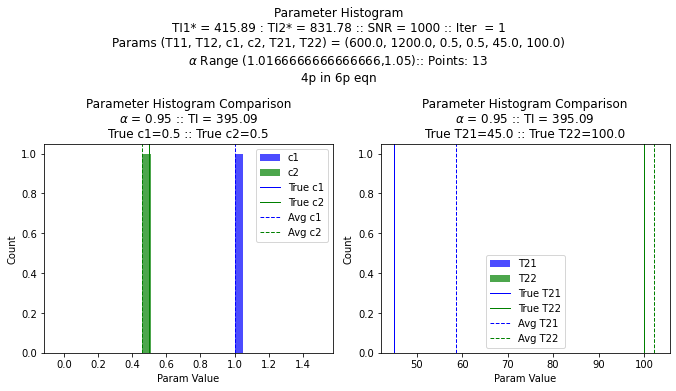

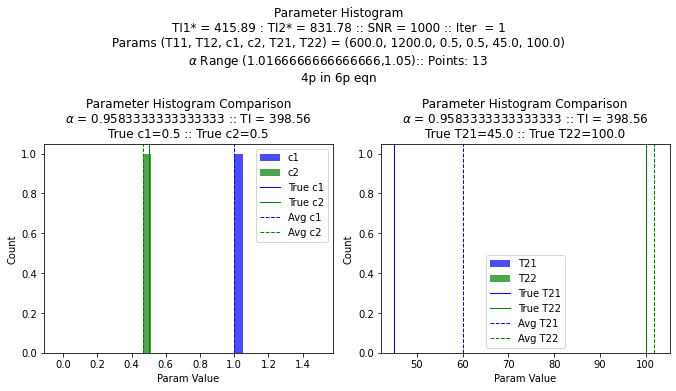

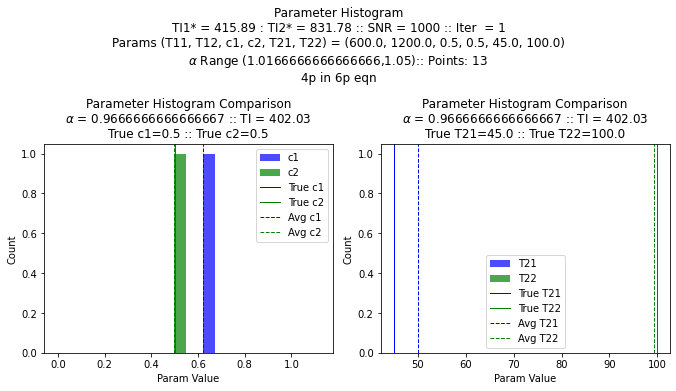

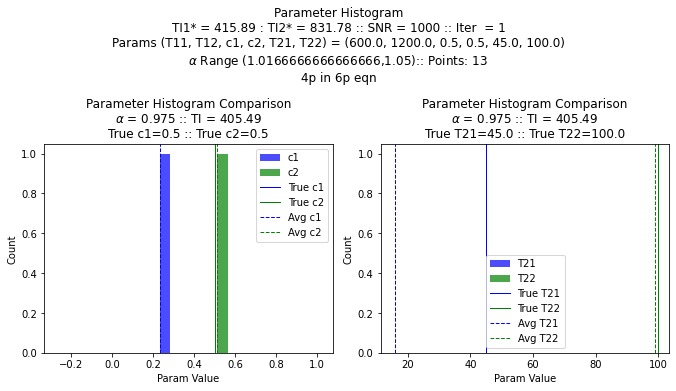

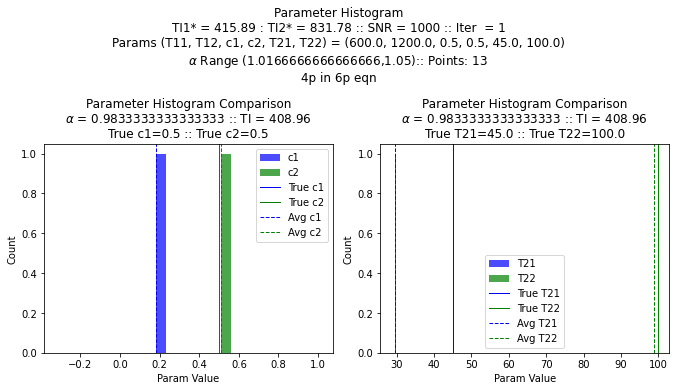

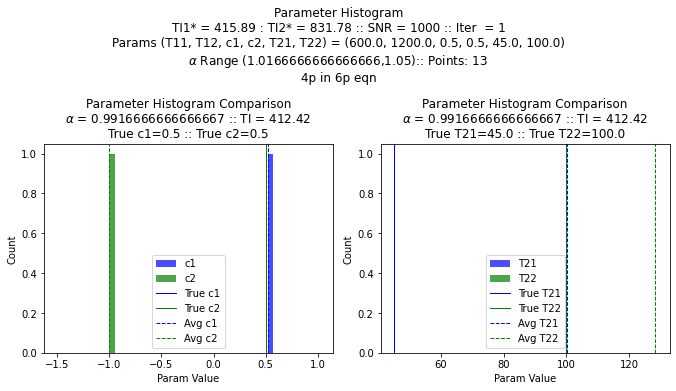

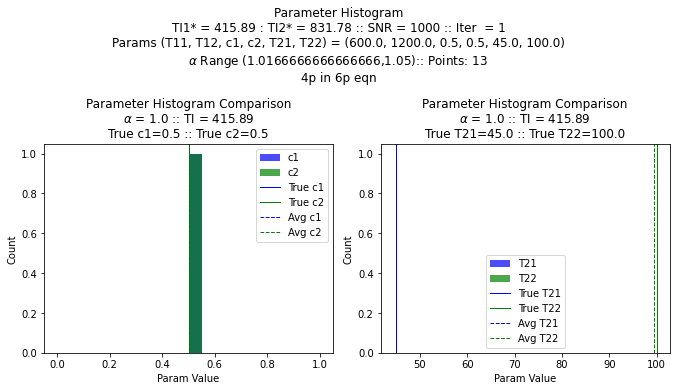

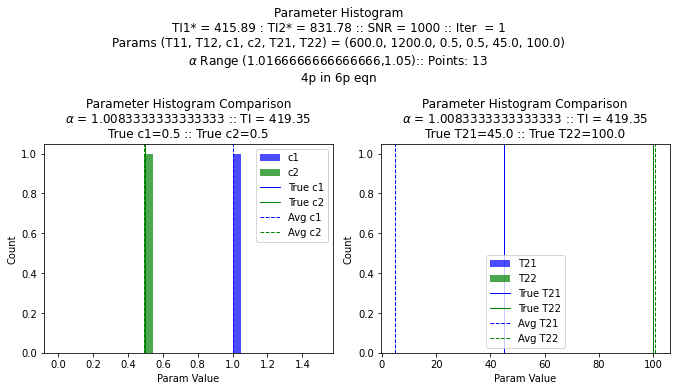

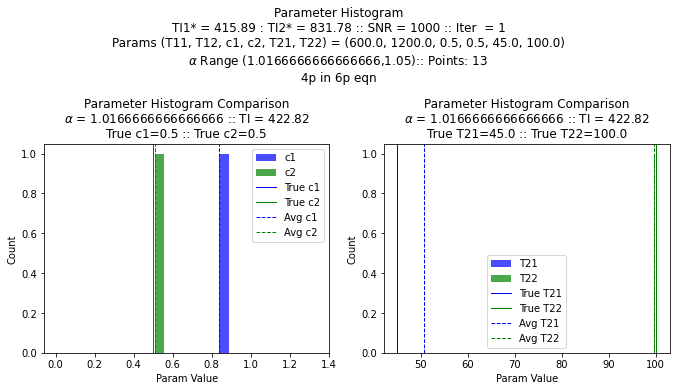

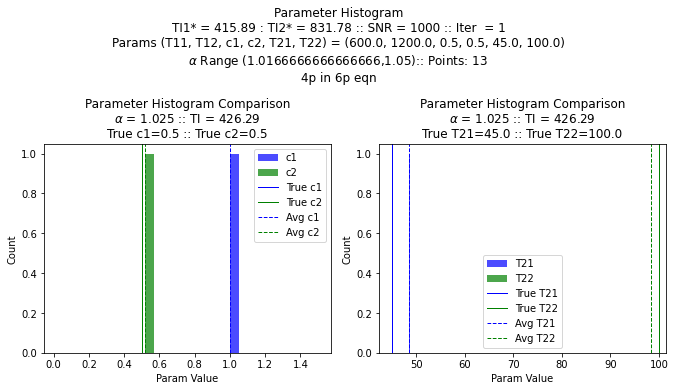

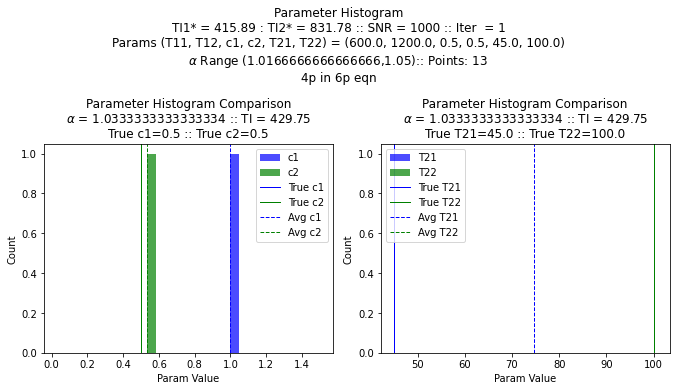

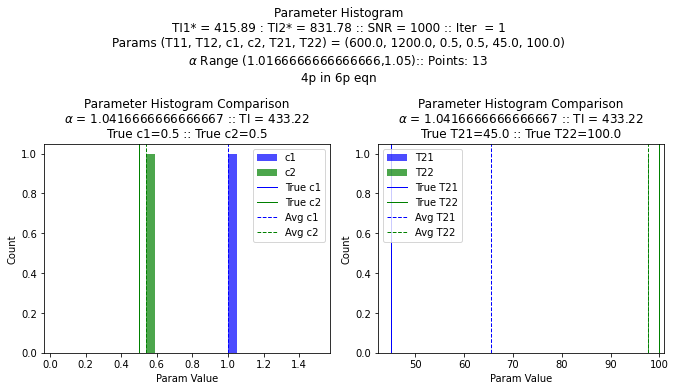

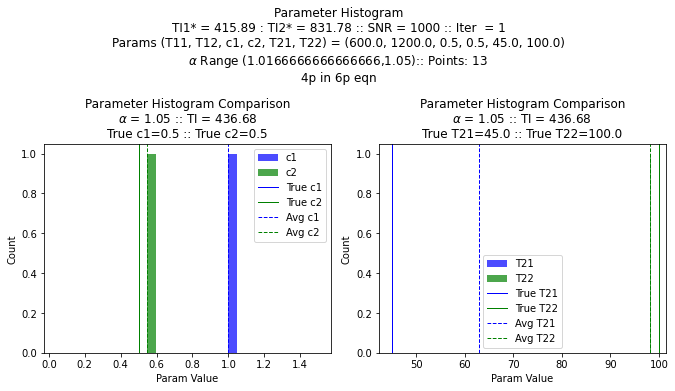

In [80]:
if histPlot:
    for k in range(paramStore_2E.shape[0]):
        paramData = paramStore_2E[k,:,:].copy()
        fig, ax = plt.subplots(1,2, figsize=(9.5,5.5), tight_layout=True)
        fig.suptitle("Parameter Histogram" + details)

        TI = TI_array[k]

        if dModel:
            true_d1 = d_value(TI, c1, T11)
            true_d2 = d_value(TI, c2, T12)

            plotParams = (true_d1, true_d2, T21, T22)
        else:
            plotParams = realParams
        
        for ii in range(2):
            #Construct a nice figure of each of the two 
            ax[ii].hist(x=paramData[:,2*ii], bins=20, color='b', label = estParams[2*ii], alpha = 0.7)
            ax[ii].hist(x=paramData[:,2*ii+1], bins=20, color='g', label = estParams[2*ii+1], alpha = 0.7)
            ax[ii].set_xlabel('Param Value')
            ax[ii].set_ylabel('Count')
            ax[ii].axvline(x=plotParams[2*ii], linewidth=1, label= 'True ' + estParams[2*ii], color='b')
            ax[ii].axvline(x=plotParams[2*ii+1], linewidth=1, label= 'True ' + estParams[2*ii+1], color='g')
            ax[ii].axvline(x=np.mean(paramData[:,2*ii]), linewidth=1, label= 'Avg ' + estParams[2*ii], color='b', ls = "--")
            ax[ii].axvline(x=np.mean(paramData[:,2*ii+1]), linewidth=1, label= 'Avg ' + estParams[2*ii+1], color='g', ls = "--")
            ax[ii].legend()
            ax[ii].set_title('Parameter Histogram Comparison' + 
                        '\n'+ r'$\alpha$'+ ' = ' + str(alpha_array[k]) + ' :: TI = ' + str(round(TI,2)) +
                        '\nTrue ' + estParams[2*ii] + '=' + str(round(plotParams[2*ii],2)) + ' :: ' 
                        'True ' + estParams[2*ii+1] + '=' + str(round(plotParams[2*ii+1],2)))
        plt.show()

### dModel Specific Parameter Histogram

In [81]:
if histPlot and dModel:
    for k in range(paramStore_2E.shape[0]):
        paramData = paramStore_2E[k,:,:].copy()
        fig, ax = plt.subplots(1,2, figsize=(9.5,5.5), tight_layout=True)
        fig.suptitle("Calculated Parameter Histogram" + details)

        estParamsTemp = ParamTitle_6p[2:np.size(ParamTitle_6p)]

        TI = TI_array[k]

        if TI==TI1star or TI==TI2star:
            fig.suptitle("Skipped nullpoint")
            continue

        paramData[:,0] = paramData[:,0]/(1-2*np.exp(-TI/T11)) #calculating all of the c1 values
        paramData[:,1] = paramData[:,1]/(1-2*np.exp(-TI/T12)) #calculating all of the c2 values
        
        for ii in range(2):
            #Construct a nice figure of each of the two 
            ax[ii].hist(x=paramData[:,2*ii], bins=20, color='b', label = estParamsTemp[2*ii], alpha = 0.7)
            ax[ii].hist(x=paramData[:,2*ii+1], bins=20, color='g', label = estParamsTemp[2*ii+1], alpha = 0.7)
            ax[ii].set_xlabel('Param Value')
            ax[ii].set_ylabel('Count')
            ax[ii].axvline(x=realParams[2*ii], linewidth=1, label= 'True ' + estParamsTemp[2*ii], color='b')
            ax[ii].axvline(x=realParams[2*ii+1], linewidth=1, label= 'True ' +estParamsTemp[2*ii+1], color='g')
            ax[ii].axvline(x=np.mean(paramData[:,2*ii]), linewidth=1, label= 'Avg ' + estParamsTemp[2*ii], color='b', ls = "--")
            ax[ii].axvline(x=np.mean(paramData[:,2*ii+1]), linewidth=1, label= 'Avg ' + estParamsTemp[2*ii+1], color='g', ls = "--")
            ax[ii].legend()
            ax[ii].set_title('Parameter Histogram Comparison' + 
                        '\n'+ r'$\alpha$'+ ' = ' + str(alpha_array[k]) + ' :: TI = ' + str(round(TI,2)) +
                        '\nTrue ' + estParamsTemp[2*ii] + '=' + str(round(realParams[2*ii],2)) + ' :: ' 
                        'True ' + estParamsTemp[2*ii+1] + '=' + str(round(realParams[2*ii+1],2)))
        plt.show()

### Density Plot of Signals

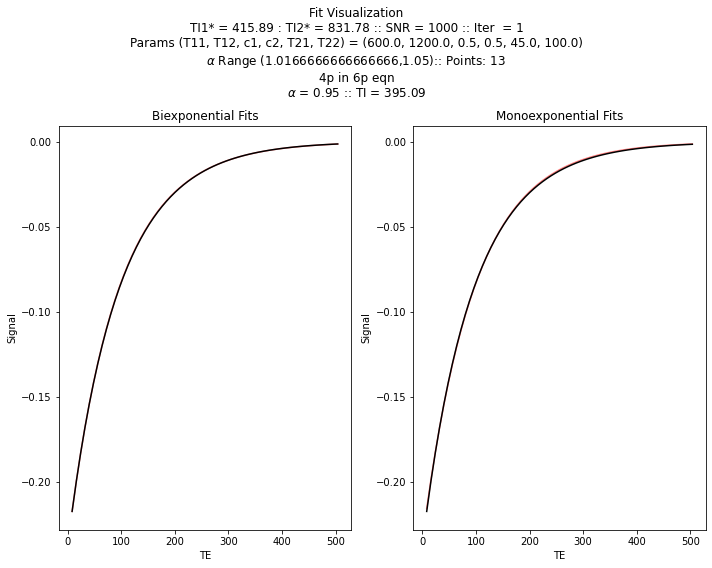

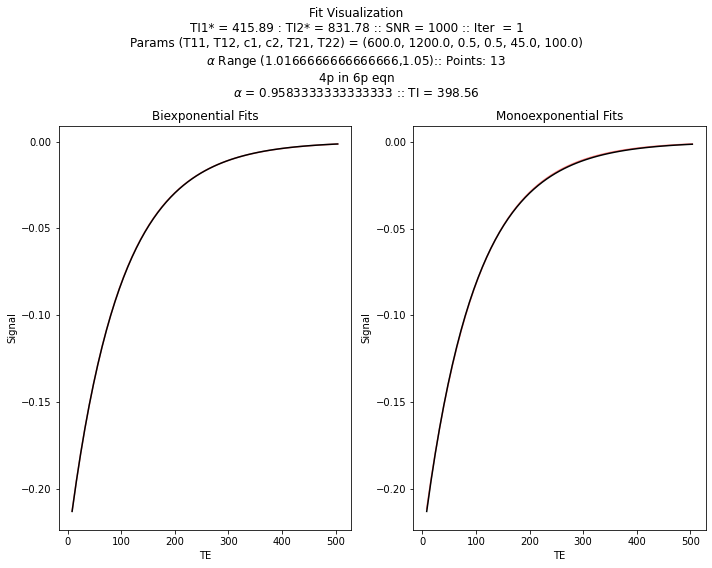

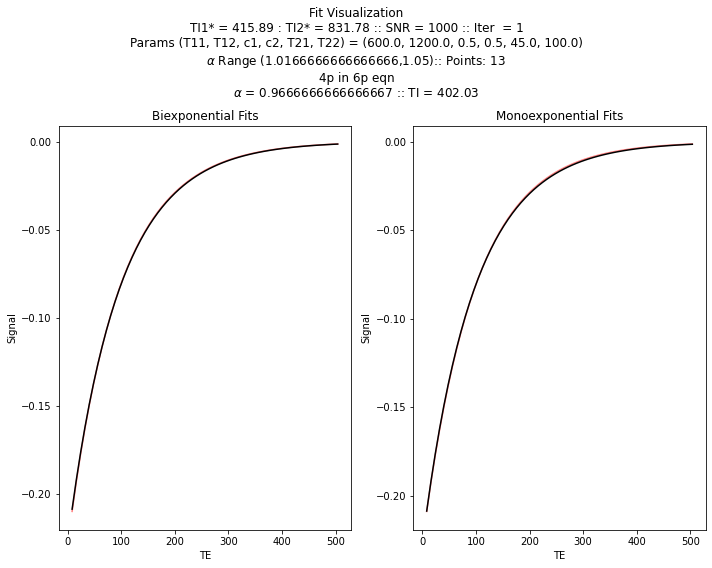

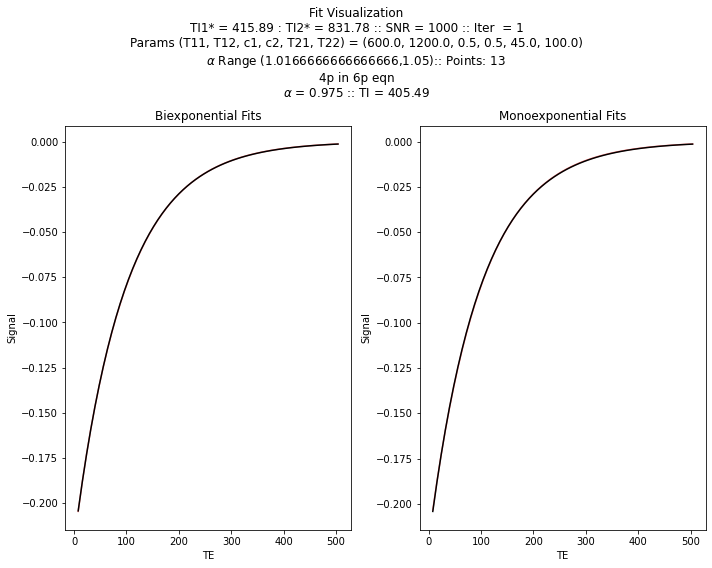

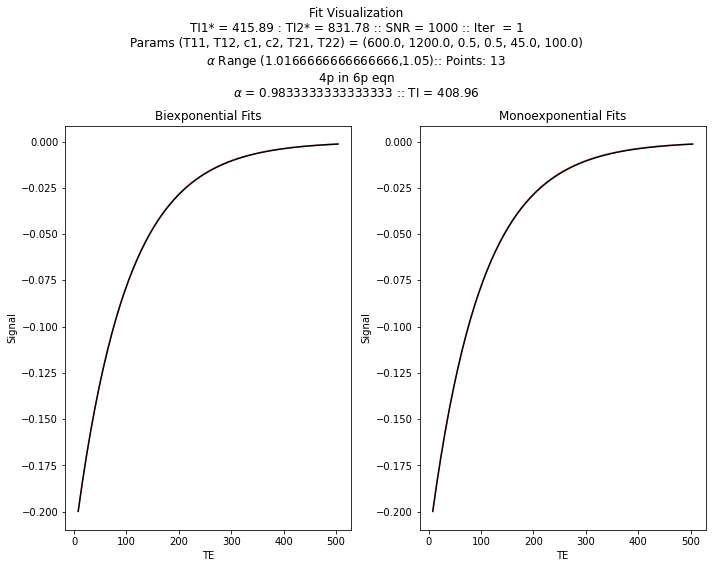

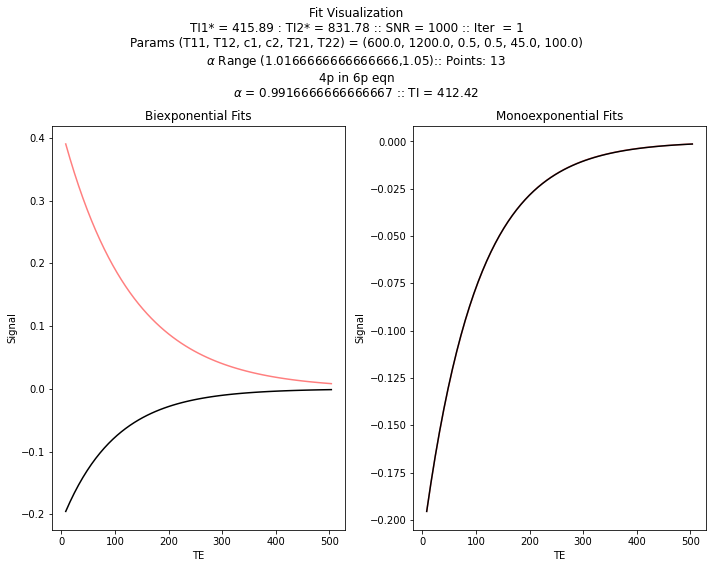

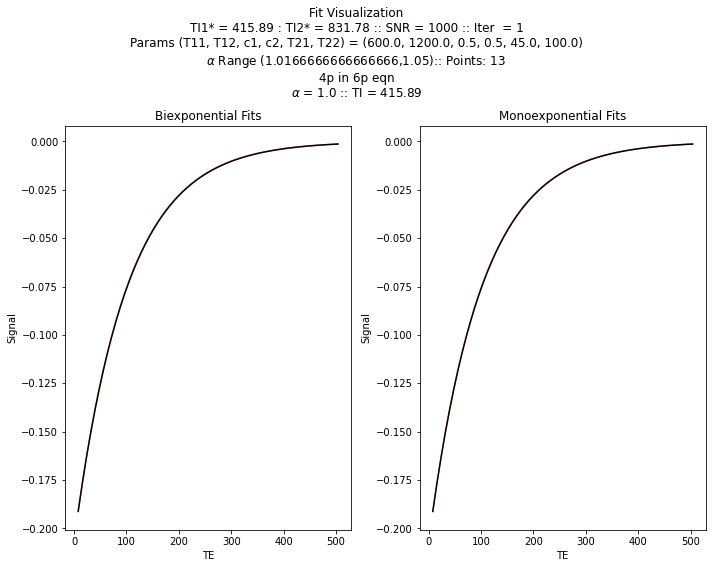

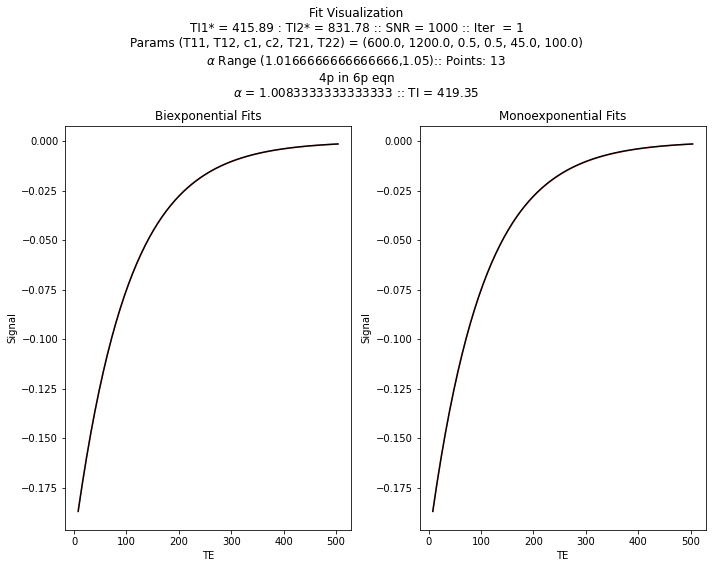

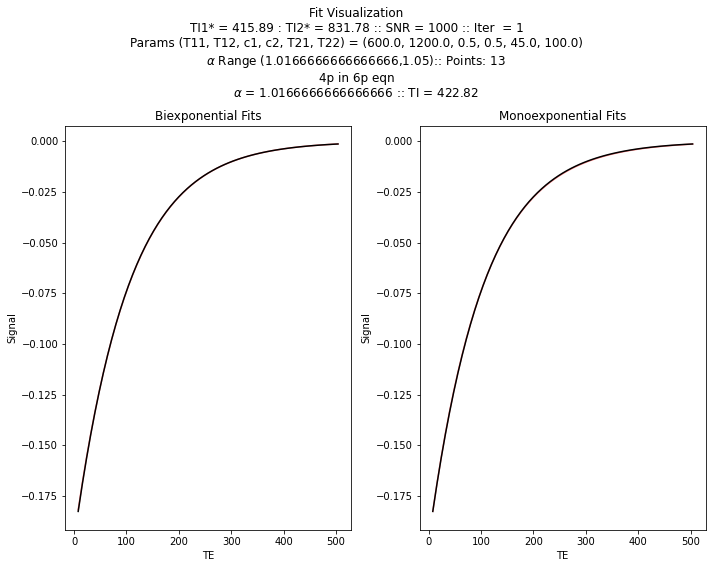

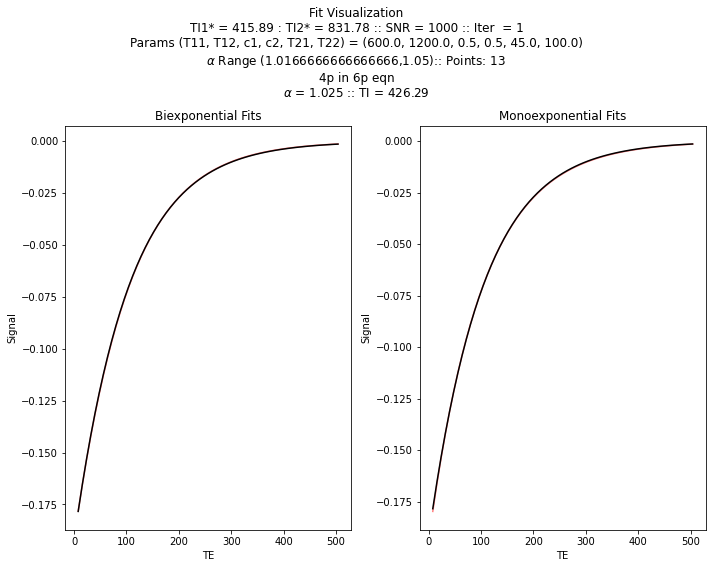

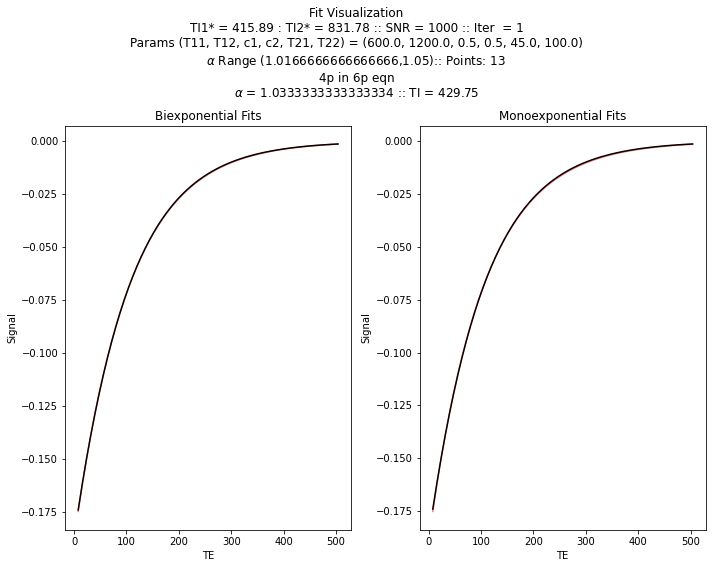

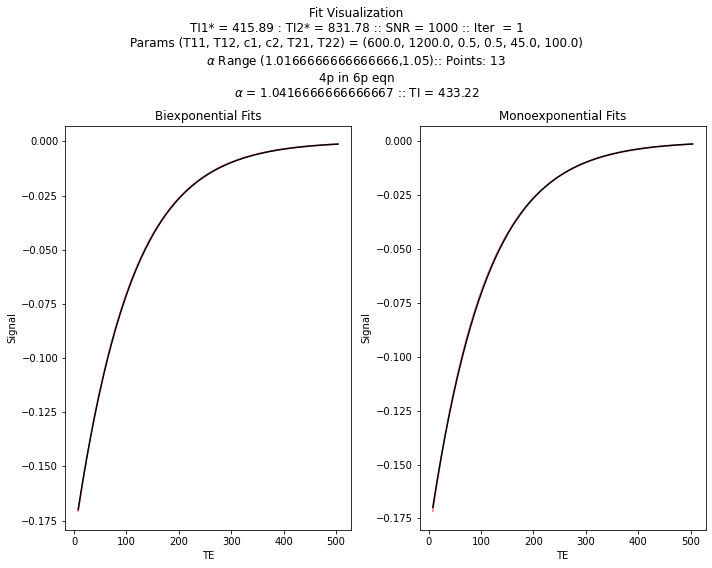

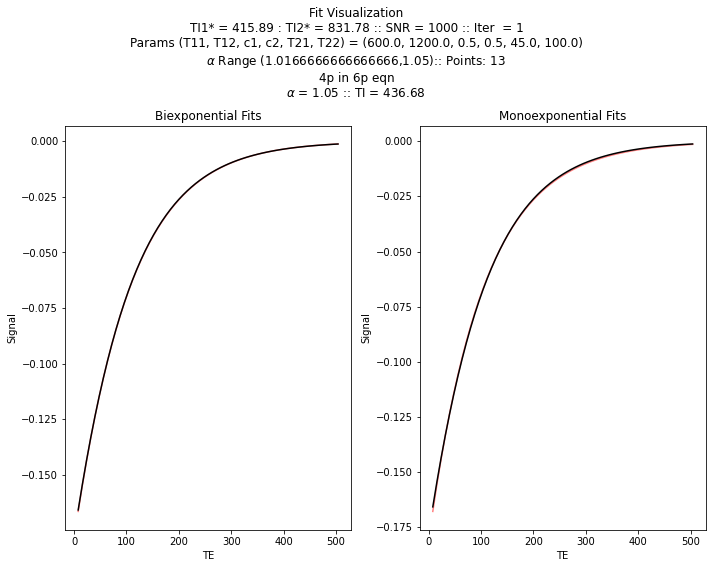

In [82]:
if denPlot:
    for k in range(paramStore_2E.shape[0]):

        TI = TI_array[k]
        trueDat = S_biX_6p(TE_series, TI, T11, T12, c1, c2, T21, T22)

        fig, ax = plt.subplots(1,2, figsize=(10,8), tight_layout=True)

        fig.suptitle('Fit Visualization' + details + 
                        '\n'+ r'$\alpha$'+ ' = ' + str(alpha_array[k]) + ' :: TI = ' + str(round(TI,2)))
        
        for rep in range(iterCount):
            ax[0].plot(TE_series, sigStore_2E[k,rep,:], color='r', alpha = 0.5)
            ax[1].plot(TE_series, sigStore_1E[k,rep,:], color='r', alpha = 0.5)

        ax[0].plot(TE_series, trueDat, label = "True Data", color='k', alpha = 1)
        ax[1].plot(TE_series, trueDat, label = "True Data", color='k', alpha = 1)

        ax[0].set_xlabel("TE")
        ax[1].set_xlabel("TE")
        ax[0].set_ylabel("Signal")
        ax[1].set_ylabel("Signal")
        ax[0].set_title("Biexponential Fits")
        ax[1].set_title("Monoexponential Fits")

        plt.show()

### Standard Deviation

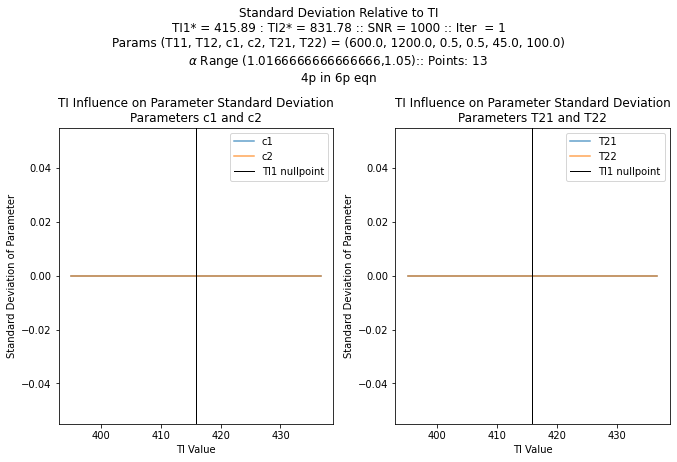

In [83]:
if stdPlot:
    fig, ax = plt.subplots(1,2, figsize=(9.5,6.5), tight_layout=True)
    fig.suptitle('Standard Deviation Relative to TI' + details)
    for i in range(2):
        ax[i].plot(TI_array,stdStore[:,2*i], label = estParams[2*i], alpha = 0.7)
        ax[i].plot(TI_array,stdStore[:,2*i+1], label = estParams[2*i+1], alpha = 0.7)
        # ax[i].plot(TI_array,mono_std[:,i], label = MonoTitle[i], alpha = 0.7)
        ax[i].axvline(x=TI1star, linewidth=1, label= 'TI1 nullpoint', color='k')
        if bothTI:
            ax[i].axvline(x=TI2star, linewidth=1, label= 'TI2 nullpoint', color='k', ls = '--')
        ax[i].set_xlabel('TI Value')
        ax[i].set_ylabel('Standard Deviation of Parameter')
        ax[i].set_title('TI Influence on Parameter Standard Deviation' + '\nParameters ' + estParams[2*i] + ' and ' + estParams[2*i+1])
        ax[i].legend()
    plt.show()

### Condition Number Plots

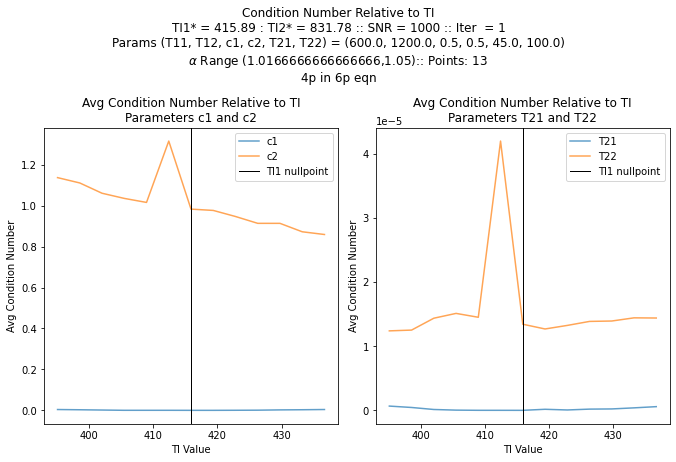

C:\Users\griff\AppData\Local\Temp\ipykernel_9748\1623308743.py:18: RuntimeWarning: divide by zero encountered in divide
  CN_normalized = CNStore/np.min(CNStore, axis = 2, keepdims = True) #minimizes along the condition number for each run
C:\Users\griff\AppData\Local\Temp\ipykernel_9748\1623308743.py:18: RuntimeWarning: invalid value encountered in divide
  CN_normalized = CNStore/np.min(CNStore, axis = 2, keepdims = True) #minimizes along the condition number for each run


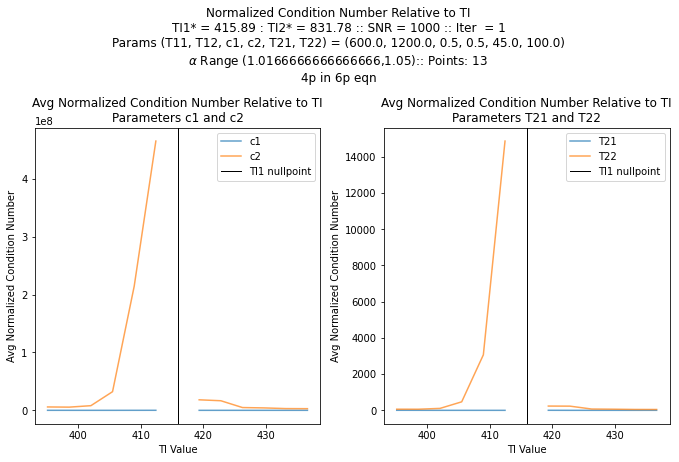

In [84]:
if cNPlot:
    fig, ax = plt.subplots(1,2, figsize=(9.5,6.5), tight_layout=True)
    fig.suptitle('Condition Number Relative to TI' + details)
    for i in range(2):
        ax[i].plot(TI_array,avgCNStore[:,2*i], label = estParams[2*i], alpha = 0.7)
        ax[i].plot(TI_array,avgCNStore[:,2*i+1], label = estParams[2*i+1], alpha = 0.7)
        ax[i].axvline(x=TI1star, linewidth=1, label= 'TI1 nullpoint', color='k')
        if bothTI:
            ax[i].axvline(x=TI2star, linewidth=1, label= 'TI2 nullpoint', color='k', ls = '--')
        ax[i].set_xlabel('TI Value')
        ax[i].set_ylabel('Avg Condition Number')
        ax[i].set_title('Avg Condition Number Relative to TI' +
                            '\nParameters ' + estParams[2*i] + ' and ' + estParams[2*i+1])
        ax[i].legend()
    plt.show()


CN_normalized = CNStore/np.min(CNStore, axis = 2, keepdims = True) #minimizes along the condition number for each run
CN_normalized = np.mean(CN_normalized, axis = 1)


fig, ax = plt.subplots(1,2, figsize=(9.5,6.5), tight_layout=True)
fig.suptitle('Normalized Condition Number Relative to TI' + details)
for i in range(2):
    ax[i].plot(TI_array,CN_normalized[:,2*i], label = estParams[2*i], alpha = 0.7)
    ax[i].plot(TI_array,CN_normalized[:,2*i+1], label = estParams[2*i+1], alpha = 0.7)
    ax[i].axvline(x=TI1star, linewidth=1, label= 'TI1 nullpoint', color='k')
    if bothTI:
        ax[i].axvline(x=TI2star, linewidth=1, label= 'TI2 nullpoint', color='k', ls = '--')
    ax[i].set_xlabel('TI Value')
    ax[i].set_ylabel('Avg Normalized Condition Number')
    # ax[i].set_ylim([0,10])
    ax[i].set_title('Avg Normalized Condition Number Relative to TI' +
                        '\nParameters ' + estParams[2*i] + ' and ' + estParams[2*i+1])
    ax[i].legend()
plt.show()

### Residual Sum of Squares Plot

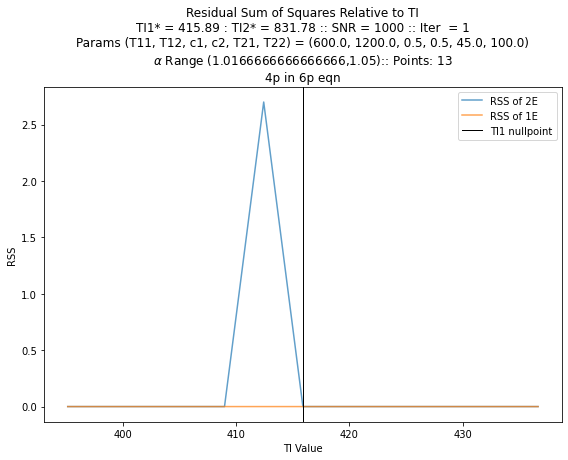

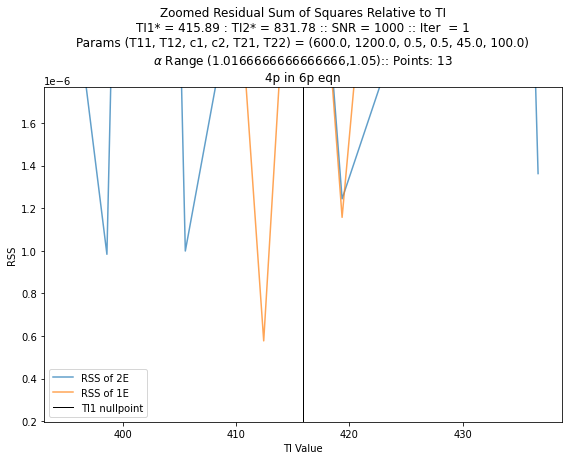

In [91]:
RSS_avg = np.mean(RSS_Store,axis = 1)
RSS_avg_1E = np.mean(RSS_Store_1E,axis = 1)
fig = plt.figure(figsize=(8,6.5), tight_layout=True)
plt.plot(TI_array,RSS_avg, label = 'RSS of 2E', alpha = 0.7)
plt.plot(TI_array,RSS_avg_1E, label = 'RSS of 1E', alpha = 0.7)
plt.axvline(x=TI1star, linewidth=1, label= 'TI1 nullpoint', color='k')
if bothTI:
    plt.axvline(x=TI2star, linewidth=1, label= 'TI2 nullpoint', color='k', ls = '--')
plt.xlabel('TI Value')
plt.ylabel('RSS')
plt.title('Residual Sum of Squares Relative to TI' + details)
plt.legend()
plt.tight_layout()
plt.show()

fig = plt.figure(figsize=(8,6.5), tight_layout=True)
plt.plot(TI_array,RSS_avg, label = 'RSS of 2E', alpha = 0.7)
plt.plot(TI_array,RSS_avg_1E, label = 'RSS of 1E', alpha = 0.7)
plt.axvline(x=TI1star, linewidth=1, label= 'TI1 nullpoint', color='k')
if bothTI:
    plt.axvline(x=TI2star, linewidth=1, label= 'TI2 nullpoint', color='k', ls = '--')
plt.xlabel('TI Value')
plt.ylabel('RSS')
plt.title('Zoomed Residual Sum of Squares Relative to TI' + details)
plt.ylim([0.2*np.min(RSS_avg),1.8*np.min(RSS_avg)])
plt.legend()
plt.tight_layout()
plt.show()

### L2 Norm Plot

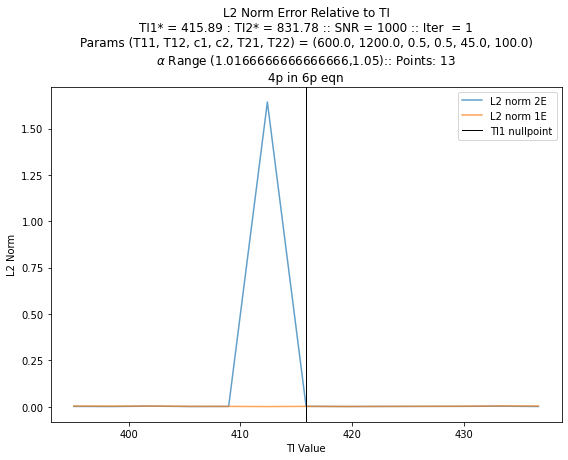

In [86]:
Err_avg = np.mean(errStore,axis = 1)
Err_avg_1E = np.mean(errStore_1E,axis = 1)
fig = plt.figure(figsize=(8,6.5), tight_layout=True)
plt.plot(TI_array,Err_avg, label = 'L2 norm 2E', alpha = 0.7)
plt.plot(TI_array,Err_avg_1E, label = 'L2 norm 1E', alpha = 0.7)
plt.axvline(x=TI1star, linewidth=1, label= 'TI1 nullpoint', color='k')
if bothTI:
    plt.axvline(x=TI2star, linewidth=1, label= 'TI2 nullpoint', color='k', ls = '--')
plt.xlabel('TI Value')
plt.ylabel('L2 Norm')
plt.title('L2 Norm Error Relative to TI' + details)
plt.legend()
plt.tight_layout()
plt.show()

### Information Criteria - AIC, BIC, R2, Cp

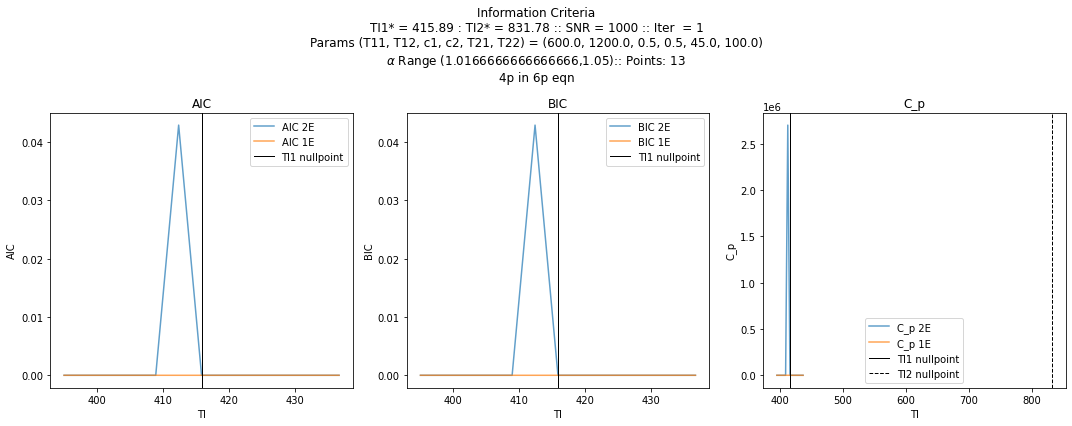

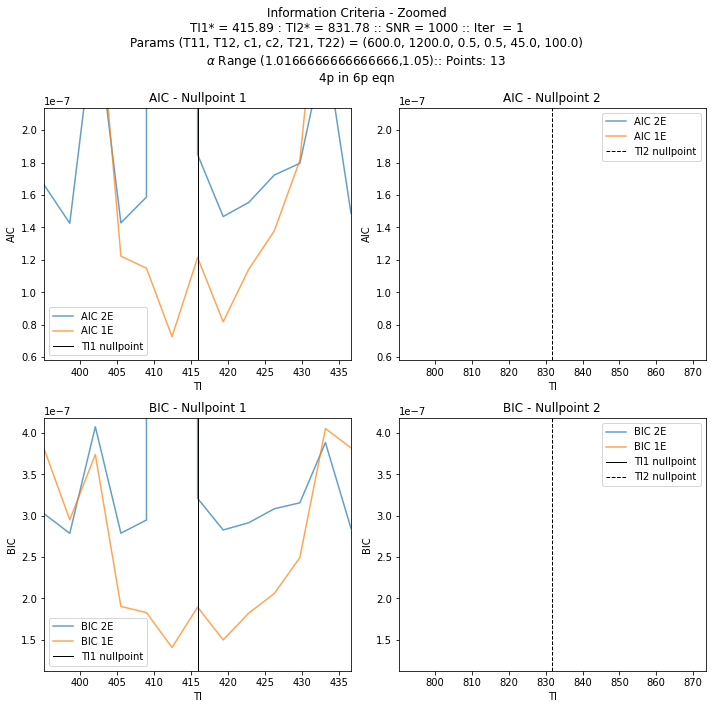

In [87]:
AIC_2E = 1/TE_series.shape[0] * (RSS_avg + 2 * np.size(estParams)*noiseSigma**2)
AIC_1E = 1/TE_series.shape[0] * (RSS_avg_1E + 2 * np.size(MonoTitle)*noiseSigma**2)

BIC_2E = 1/TE_series.shape[0] * (RSS_avg + np.log(TE_series.shape[0]) * np.size(estParams)*noiseSigma**2)
BIC_1E = 1/TE_series.shape[0] * (RSS_avg_1E + np.log(TE_series.shape[0]) * np.size(MonoTitle)*noiseSigma**2)

Cp_2E = RSS_avg/noiseSigma**2 + 2*np.size(estParams) - TE_series.shape[0]
Cp_1E = RSS_avg_1E/noiseSigma**2 + 2*np.size(MonoTitle) - TE_series.shape[0]

fig, ax = plt.subplots(1,3,figsize=(15,6), tight_layout=True)
fig.suptitle('Information Criteria' + details)


ax[0].plot(TI_array, AIC_2E, label = 'AIC 2E', alpha = 0.7)
ax[0].plot(TI_array, AIC_1E, label = 'AIC 1E', alpha = 0.7)
ax[0].set_title('AIC')
ax[0].axvline(x=TI1star, linewidth=1, label= 'TI1 nullpoint', color='k')
if bothTI:
    ax[0].axvline(x=TI2star, linewidth=1, label= 'TI2 nullpoint', color='k', ls = '--')
ax[0].set_xlabel('TI')
ax[0].set_ylabel('AIC')
ax[0].legend()

ax[1].plot(TI_array, BIC_2E, label = 'BIC 2E', alpha = 0.7)
ax[1].plot(TI_array, BIC_1E, label = 'BIC 1E', alpha = 0.7)
ax[1].set_title('BIC')
ax[1].axvline(x=TI1star, linewidth=1, label= 'TI1 nullpoint', color='k')
if bothTI:
    ax[1].axvline(x=TI2star, linewidth=1, label= 'TI2 nullpoint', color='k', ls = '--')
ax[1].set_xlabel('TI')
ax[1].set_ylabel('BIC')
ax[1].legend()

ax[2].plot(TI_array, Cp_2E, label = 'C_p 2E', alpha = 0.7)
ax[2].plot(TI_array, Cp_1E, label = 'C_p 1E', alpha = 0.7)
ax[2].set_title('C_p')
ax[2].axvline(x=TI1star, linewidth=1, label= 'TI1 nullpoint', color='k')
ax[2].axvline(x=TI2star, linewidth=1, label= 'TI2 nullpoint', color='k', ls = '--')
ax[2].set_xlabel('TI')
ax[2].set_ylabel('C_p')
ax[2].legend()

fig, ax = plt.subplots(2,2,figsize=(10,10), tight_layout=True)
fig.suptitle('Information Criteria - Zoomed' + details)

minVal_1E = min(AIC_1E)
minVal_2E = min(AIC_2E)
ax[0,0].plot(TI_array, AIC_2E, label = 'AIC 2E', alpha = 0.7)
ax[0,0].plot(TI_array, AIC_1E, label = 'AIC 1E', alpha = 0.7)
ax[0,0].set_title('AIC - Nullpoint 1')
ax[0,0].axvline(x=TI1star, linewidth=1, label= 'TI1 nullpoint', color='k')
ax[0,0].set_xlabel('TI')
ax[0,0].set_ylabel('AIC')
ax[0,0].set_ylim([0.8*minVal_1E,1.5*minVal_2E])
ax[0,0].set_xlim([(1-rad)*TI1star, (1+rad)*TI1star])
ax[0,0].legend()

ax[0,1].plot(TI_array, AIC_2E, label = 'AIC 2E', alpha = 0.7)
ax[0,1].plot(TI_array, AIC_1E, label = 'AIC 1E', alpha = 0.7)
ax[0,1].set_title('AIC - Nullpoint 2')
ax[0,1].axvline(x=TI2star, linewidth=1, label= 'TI2 nullpoint', color='k', ls = '--')
ax[0,1].set_xlabel('TI')
ax[0,1].set_ylabel('AIC')
ax[0,1].set_ylim([0.8*minVal_1E,1.5*minVal_2E])
ax[0,1].set_xlim([(1-rad)*TI2star, (1+rad)*TI2star])
ax[0,1].legend()

minVal_1E = min(BIC_1E)
minVal_2E = min(BIC_2E)
ax[1,0].plot(TI_array, BIC_2E, label = 'BIC 2E', alpha = 0.7)
ax[1,0].plot(TI_array, BIC_1E, label = 'BIC 1E', alpha = 0.7)
ax[1,0].set_title('BIC - Nullpoint 1')
ax[1,0].axvline(x=TI1star, linewidth=1, label= 'TI1 nullpoint', color='k')
ax[1,0].set_xlabel('TI')
ax[1,0].set_ylabel('BIC')
ax[1,0].set_ylim([0.8*minVal_1E,1.5*minVal_2E])
ax[1,0].set_xlim([(1-rad)*TI1star, (1+rad)*TI1star])
ax[1,0].legend()

ax[1,1].plot(TI_array, BIC_2E, label = 'BIC 2E', alpha = 0.7)
ax[1,1].plot(TI_array, BIC_1E, label = 'BIC 1E', alpha = 0.7)
ax[1,1].set_title('BIC - Nullpoint 2')
ax[1,1].axvline(x=TI1star, linewidth=1, label= 'TI1 nullpoint', color='k')
ax[1,1].axvline(x=TI2star, linewidth=1, label= 'TI2 nullpoint', color='k', ls = '--')
ax[1,1].set_xlabel('TI')
ax[1,1].set_ylabel('BIC')
ax[1,1].set_ylim([0.8*minVal_1E,1.5*minVal_2E])
ax[1,1].set_xlim([(1-rad)*TI2star, (1+rad)*TI2star])
ax[1,1].legend()


### Rule Breaking Plot

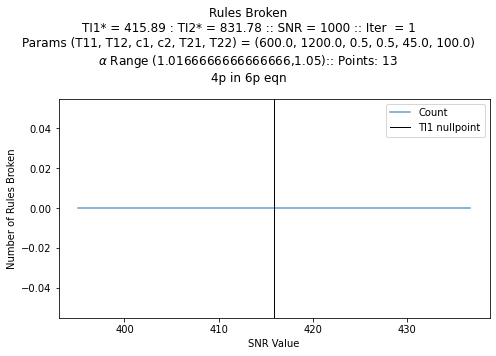

In [88]:
fig = plt.figure(figsize=(7,5), tight_layout=True)
fig.suptitle('Rules Broken' + details)
plt.plot(TI_array, numRuleBreak, label= 'Count', alpha = 0.7)
plt.axvline(x=TI1star, linewidth=1, label= 'TI1 nullpoint', color='k')
if bothTI:
    plt.axvline(x=TI2star, linewidth=1, label= 'TI2 nullpoint', color='k', ls = '--')
plt.xlabel('SNR Value')
plt.ylabel('Number of Rules Broken')
# plt.title('Biexponential Model')
plt.legend()
plt.show()

### Sensitivity Graphs

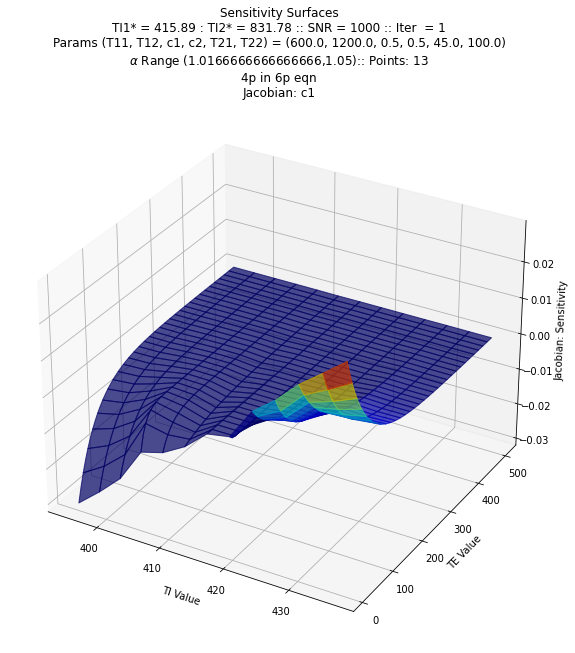

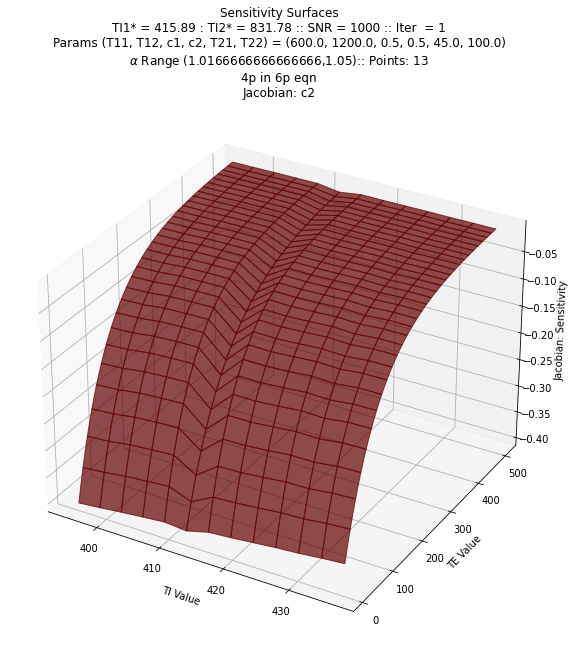

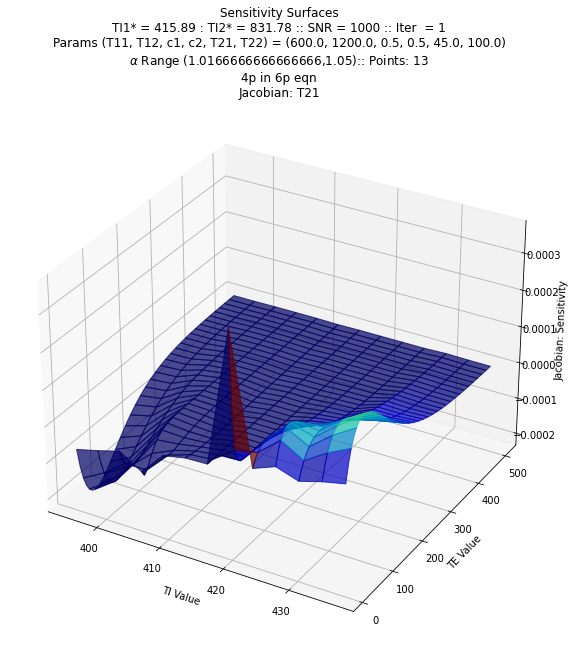

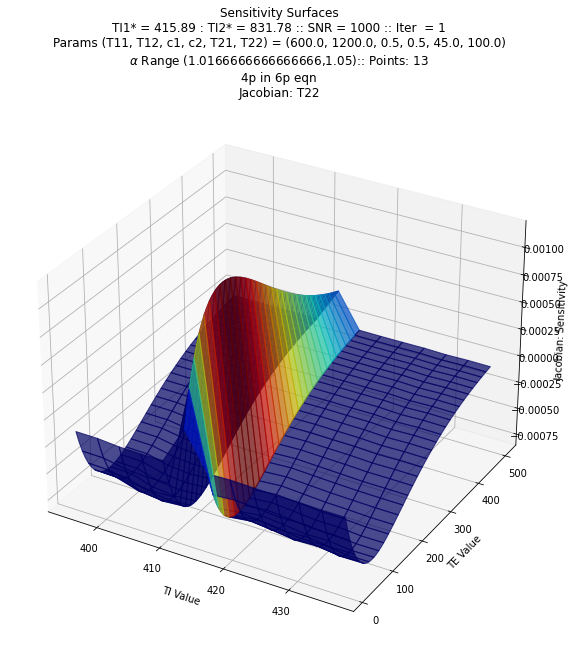

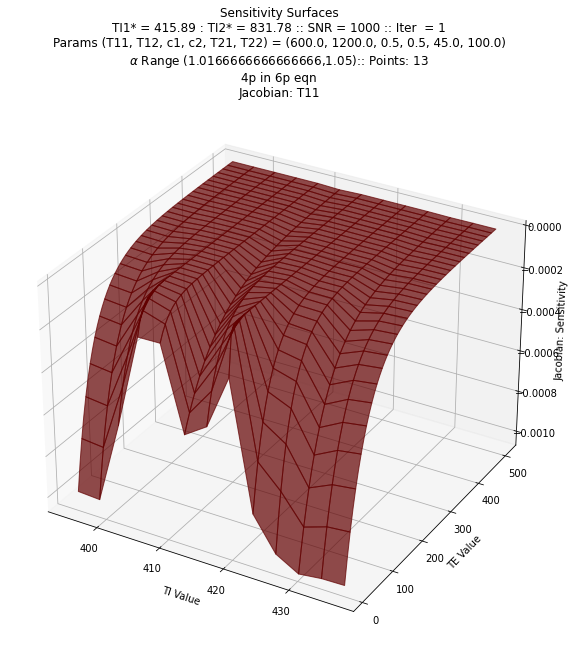

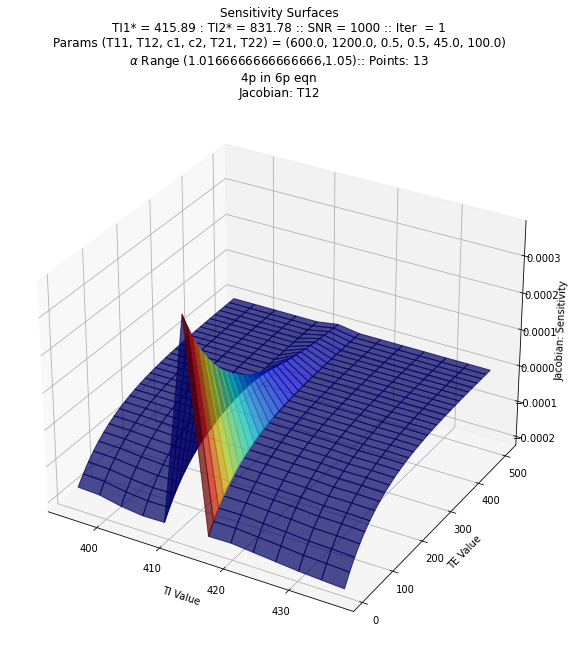

<Figure size 432x288 with 0 Axes>

In [89]:
TImg,TEmg = np.meshgrid(TI_array,TE_series)
if dModel:
    Jstore = np.zeros((TImg.shape[0],TImg.shape[1],np.size(ParamTitle_4p)))
else:
    Jstore = np.zeros((TImg.shape[0],TImg.shape[1],np.size(ParamTitle_6p)))
for i in range(Jstore.shape[0]):
    for j in range(Jstore.shape[1]):
        if dModel:
            Jstore[i,j,:] = Jacobian_4p(TEmg[i,j],*avgPStore[j,:])
        else:
            Jstore[i,j,:] = Jacobian_6p(TEmg[i,j],TImg[i,j],T11,T12,*avgPStore[j,:])
        
JacobianTitles = ["c1","c2","T21","T22","T11","T12"]


for j in range(Jstore.shape[2]):
    fig = plt.figure(figsize = (10,10))
    ax = plt.axes(projection='3d')
    my_col = cm.jet(Jstore[:,:,j]/np.amax(Jstore[:,:,j]))
    ax.plot_surface(TImg,TEmg,Jstore[:,:,j], alpha = 0.7, facecolors = my_col)
    ax.set_xlabel('TI Value')
    ax.set_ylabel('TE Value')
    ax.set_zlabel('Jacobian: Sensitivity')
    if dModel:
        ax.set_title('Sensitivity Surfaces' + details + '\nJacobian: ' + ParamTitle_4p[j])
    else:
        ax.set_title('Sensitivity Surfaces' + details + '\nJacobian: ' + JacobianTitles[j])
    plt.show()



plt.tight_layout()
plt.show()